In [1]:
import numpy as np
import scipy
import pandas as pd
import os
# from tqdm import trange
from tqdm.auto import tqdm
from empirical_updates import SecondOrderEmpirical, FirstOrderEmpirical
from gordon_updates import GordonUpdate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# sns.reset_orig()
import matplotlib
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

params = {'figure.figsize': (12.0, 8.0),
          'lines.linewidth': 2.,
          'legend.fontsize': 'xx-large',
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}

plt.rcParams.update(params)
%load_ext autoreload
%autoreload 2

In [4]:
### Set problem parameters for AM
delta = 100 # over sampling
sigma = 10e-6 # noise std
d = 800 # dimension
thetastar = np.random.normal(0, 1, d)
thetastar = thetastar/np.linalg.norm(thetastar) # ground truth

AM = SecondOrderEmpirical(thetastar, delta, sigma) # second order updates
AM.initialize() # initialize with eps correlation
thetacur_MLR = AM.thetainit # set the initial theta
T = 16 # number of iterations

### Make the gordon lists
Gordon = GordonUpdate(sigma, delta)
alpha_list_gor_AM_MLR, beta_list_gor_AM_MLR = [], []
alpha_list_gor_AM_MLR.append(AM.get_alpha(thetacur_MLR))
beta_list_gor_AM_MLR.append(AM.get_beta(thetacur_MLR))

### Find converging instance 
converging = False
while not converging:
    AM.initialize()
    thetacur_MLR = AM.thetainit
    
    ### Iterate and update
    for t in tqdm(range(T), leave=False):
        ### Resample the data
        AM.update_data()

        ### Iterate and update MLR
        thetacur_MLR = AM.iterate_MLR(thetacur_MLR) 
    if np.linalg.norm(thetacur_MLR - thetastar) < 0.01:
        converging = True
print('found a good instance!')
        
### Run AM from this initialization
num_trials = 10
alpha_AM_MLR, beta_AM_MLR = [], []
for _ in tqdm(range(num_trials)):
    ### Make the empirical lists
    alpha_list_AM_MLR, beta_list_AM_MLR = [], []
    alpha_list_AM_MLR.append(AM.get_alpha(AM.thetainit)) # initial alpha value
    beta_list_AM_MLR.append(AM.get_beta(AM.thetainit)) # initial beta value
    
    thetacur_MLR = AM.thetainit
    
    ### Iterate and update
    for t in tqdm(range(T), leave=False):
        ### Resample the data
        AM.update_data()

        ### Iterate and update MLR
        thetacur_MLR = AM.iterate_MLR(thetacur_MLR) 
        alpha_list_AM_MLR.append(AM.get_alpha(thetacur_MLR))
        beta_list_AM_MLR.append(AM.get_beta(thetacur_MLR)) 
        
    alpha_list_AM_MLR = np.array(alpha_list_AM_MLR)
    beta_list_AM_MLR = np.array(beta_list_AM_MLR)
    dist_list_AM_MLR = np.sqrt(beta_list_AM_MLR**2 + (alpha_list_AM_MLR  - 1)**2)
    if dist_list_AM_MLR[-1] < 0.01:
        alpha_AM_MLR.append(alpha_list_AM_MLR)
        beta_AM_MLR.append(beta_list_AM_MLR)
alpha_AM_MLR, beta_AM_MLR = np.array(alpha_AM_MLR), np.array(beta_AM_MLR)

### Make the distance list, average list, and empirical envelope
angle_list_AM_MLR = np.arctan(beta_AM_MLR/alpha_AM_MLR)
avg_angle_AM_MLR = np.mean(angle_list_AM_MLR, axis=0)
upper_AM_MLR = np.percentile(angle_list_AM_MLR, 97.5, axis=0)
lower_AM_MLR = np.percentile(angle_list_AM_MLR, 2.5, axis=0)

  0%|          | 0/16 [00:00<?, ?it/s]

found a good instance!


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [6]:
### Make the gordon list
alpha_list_gor_AM_MLR = [np.mean(alpha_AM_MLR, axis=0)[0]]
beta_list_gor_AM_MLR = [np.mean(beta_AM_MLR, axis=0)[0]]
for t in tqdm(range(T)):
    alpha_next_AM_MLR, beta_next_AM_MLR = Gordon.AM_MLR_gordon(alpha_list_gor_AM_MLR[-1], beta_list_gor_AM_MLR[-1])
    alpha_list_gor_AM_MLR.append(alpha_next_AM_MLR)
    beta_list_gor_AM_MLR.append(beta_next_AM_MLR)

alpha_list_gor_AM_MLR, beta_list_gor_AM_MLR = np.array(alpha_list_gor_AM_MLR), np.array(beta_list_gor_AM_MLR)
dist_list_gor_AM_MLR = np.sqrt(beta_list_gor_AM_MLR**2 + (alpha_list_gor_AM_MLR - 1)**2)
angle_list_gor_AM_MLR = np.arctan(beta_list_gor_AM_MLR/alpha_list_gor_AM_MLR)

  0%|          | 0/16 [00:00<?, ?it/s]

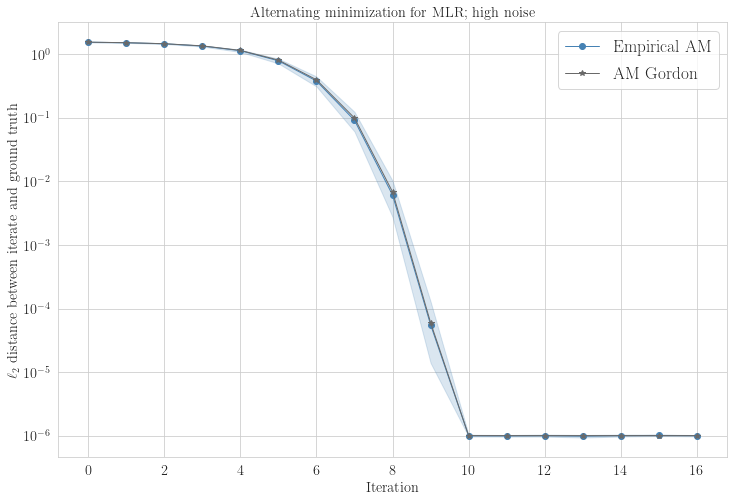

In [10]:
plt.plot(np.arange(T + 1), np.abs(avg_angle_AM_MLR)\
         , marker='o', linewidth=1, color = 'steelblue', label='Empirical AM')
# plt.plot(np.arange(T + 1), np.abs(avg_dist_GD_PR)\
#          , marker='o', linewidth=1, color = 'mediumseagreen', label='Empirical GD')
plt.plot(np.arange(T + 1), np.abs(angle_list_gor_AM_MLR)\
         , marker='*', linewidth=1, color = 'dimgray', label='AM Gordon')
# plt.plot(np.arange(T + 1), np.abs(dist_list_gor_GD_PR)\
#          , marker='*', linewidth=1, color = 'dimgray', label='GD Gordon')
plt.fill_between(np.arange(T+1), lower_AM_MLR, upper_AM_MLR, color='steelblue', alpha=0.2)
# plt.fill_between(np.arange(T+1), lower_GD_PR, upper_GD_PR, color='mediumseagreen', alpha=0.2)
plt.semilogy()
plt.ylabel(r'$\ell_2$ distance between iterate and ground truth')
plt.xlabel('Iteration')
plt.title('Alternating minimization for MLR; high noise')
plt.legend()

In [12]:
### First order
GD = FirstOrderEmpirical(thetastar, delta, sigma)
num_trials = 10
alpha_GD_MLR, beta_GD_MLR = [], []
for _ in tqdm(range(num_trials)):
    ### Make the empirical lists
    alpha_list_GD_MLR, beta_list_GD_MLR = [], []
    alpha_list_GD_MLR.append(GD.get_alpha(AM.thetainit)) # initial alpha value
    beta_list_GD_MLR.append(GD.get_beta(AM.thetainit)) # initial beta value
    
    thetacur_MLR = AM.thetainit
    ### Iterate and update
    for t in tqdm(range(T), leave=False):
        ### Resample the data
        GD.update_data()

        ### Iterate and update MLR
        thetacur_MLR = GD.iterate_MLR(thetacur_MLR, 0.5) 
        alpha_list_GD_MLR.append(AM.get_alpha(thetacur_MLR))
        beta_list_GD_MLR.append(AM.get_beta(thetacur_MLR)) 

    alpha_list_GD_MLR = np.array(alpha_list_GD_MLR)
    beta_list_GD_MLR = np.array(beta_list_GD_MLR)
    alpha_GD_MLR.append(alpha_list_GD_MLR)
    beta_GD_MLR.append(beta_list_GD_MLR)
alpha_GD_MLR, beta_GD_MLR = np.array(alpha_GD_MLR), np.array(beta_GD_MLR)

### Make the distance list, average list, and empirical envelope
dist_list_GD_MLR = np.sqrt(beta_GD_MLR**2 + (alpha_GD_MLR  - 1)**2)
avg_dist_GD_MLR = np.mean(dist_list_GD_MLR, axis=0)
upper_GD_MLR = np.percentile(dist_list_GD_MLR, 97.5, axis=0)
lower_GD_MLR = np.percentile(dist_list_GD_MLR, 2.5, axis=0)

### Gordon data GD
alpha_list_gor_GD_MLR, beta_list_gor_GD_MLR = [], []
alpha_list_gor_GD_MLR.append(AM.get_alpha(AM.thetainit))
beta_list_gor_GD_MLR.append(AM.get_beta(AM.thetainit))
for t in tqdm(range(T)):
    alpha_next_GD_MLR, beta_next_GD_MLR = Gordon.GD_MLR_gordon(alpha_list_gor_GD_MLR[-1], beta_list_gor_GD_MLR[-1], 0.5)
    alpha_list_gor_GD_MLR.append(alpha_next_GD_MLR)
    beta_list_gor_GD_MLR.append(beta_next_GD_MLR)

alpha_list_gor_GD_MLR, beta_list_gor_GD_MLR = np.array(alpha_list_gor_GD_MLR), np.array(beta_list_gor_GD_MLR)
dist_list_gor_GD_MLR = np.sqrt(beta_list_gor_GD_MLR**2 + (alpha_list_gor_GD_MLR - 1)**2)
angle_list_gor_GD_MLR = np.arctan(beta_list_gor_GD_MLR/alpha_list_gor_GD_MLR)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [15]:
### Make the distance list, average list, and empirical envelope
angle_list_GD_MLR = np.arctan(beta_GD_MLR/alpha_GD_MLR)
avg_angle_GD_MLR = np.mean(angle_list_GD_MLR, axis=0)
upper_GD_MLR = np.percentile(angle_list_GD_MLR, 97.5, axis=0)
lower_GD_MLR = np.percentile(angle_list_GD_MLR, 2.5, axis=0)

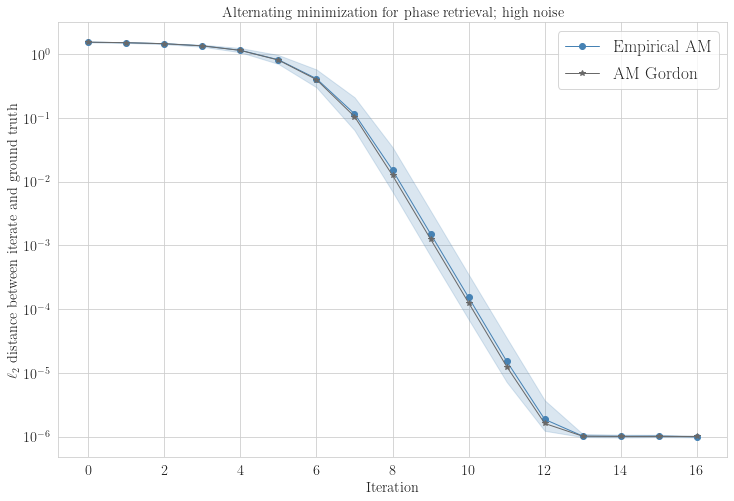

In [16]:
plt.plot(np.arange(T + 1), np.abs(avg_angle_GD_MLR)\
         , marker='o', linewidth=1, color = 'steelblue', label='Empirical AM')
# plt.plot(np.arange(T + 1), np.abs(avg_dist_GD_MLR)\
#          , marker='o', linewidth=1, color = 'mediumseagreen', label='Empirical GD')
plt.plot(np.arange(T + 1), np.abs(angle_list_gor_GD_MLR)\
         , marker='*', linewidth=1, color = 'dimgray', label='AM Gordon')
# plt.plot(np.arange(T + 1), np.abs(dist_list_gor_GD_MLR)\
#          , marker='*', linewidth=1, color = 'dimgray', label='GD Gordon')
plt.fill_between(np.arange(T+1), lower_GD_MLR, upper_GD_MLR, color='steelblue', alpha=0.2)
# plt.fill_between(np.arange(T+1), lower_GD_MLR, upper_GD_MLR, color='mediumseagreen', alpha=0.2)
plt.semilogy()
plt.ylabel(r'$\ell_2$ distance between iterate and ground truth')
plt.xlabel('Iteration')
plt.title('Alternating minimization for phase retrieval; high noise')
plt.legend()

In [18]:
### Save data in .dat file
data = np.array([np.arange(T+1)\
                 , avg_angle_AM_MLR\
                 , lower_AM_MLR\
                 , upper_AM_MLR\
                 , angle_list_gor_AM_MLR\
                 , avg_angle_GD_MLR\
                 , lower_GD_MLR\
                 , upper_GD_MLR\
                 , angle_list_gor_GD_MLR]).transpose()
np.savetxt('global-MLR', data, \
            fmt=['%.0f'\
                 , '%.8f', '%.8f', '%.8f', '%.8f'\
                 , '%.8f', '%.8f', '%.8f', '%.8f'], \
            header='iter avgAM lowerAM upperAM gorAM avgGD lowerGD upperGD gorGD', \
            comments='# ')